# 0. About

This notebook is to try PCA with classification algorithms.
The dataset is from [Kaggle Heart Attack Analysis Prediction](https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset).

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

rs_num = 14

# 1. Loading Data

For the features: 

- Age : Age of the patient
- Sex : Sex of the patient
- exang: exercise induced angina (1 = yes; 0 = no)
- ca: number of major vessels (0-3)
- cp : Chest Pain type chest pain type
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- trtbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- rest_ecg : resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach : maximum heart rate achieved
- target : 
    - 0: less chance of heart attack
    - 1: more chance of heart attack

In [2]:
# find where the data is stored
repo_path = os.path.dirname(os.getcwd())
data_path = repo_path + '\\data\\'

In [3]:
df = pd.read_csv(
    data_path+'Heart_Attack_Analysis_Prediction_Dataset_heart.csv'
)

In [4]:
# check out the general info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None


In [5]:
# check out the head
print(df.head())

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  


Every feature looks like numerically, but we can check out the data later with the EDA.

# 2. Exploratory Data Analysis

## 2.1. Check out NA and Null

In [6]:
# check out NA
print(df.isna().sum())

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64


In [7]:
# check out Null
print(df.isnull().sum())

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64


Everything looks good!

## 2.2. Visualize Data Distribution

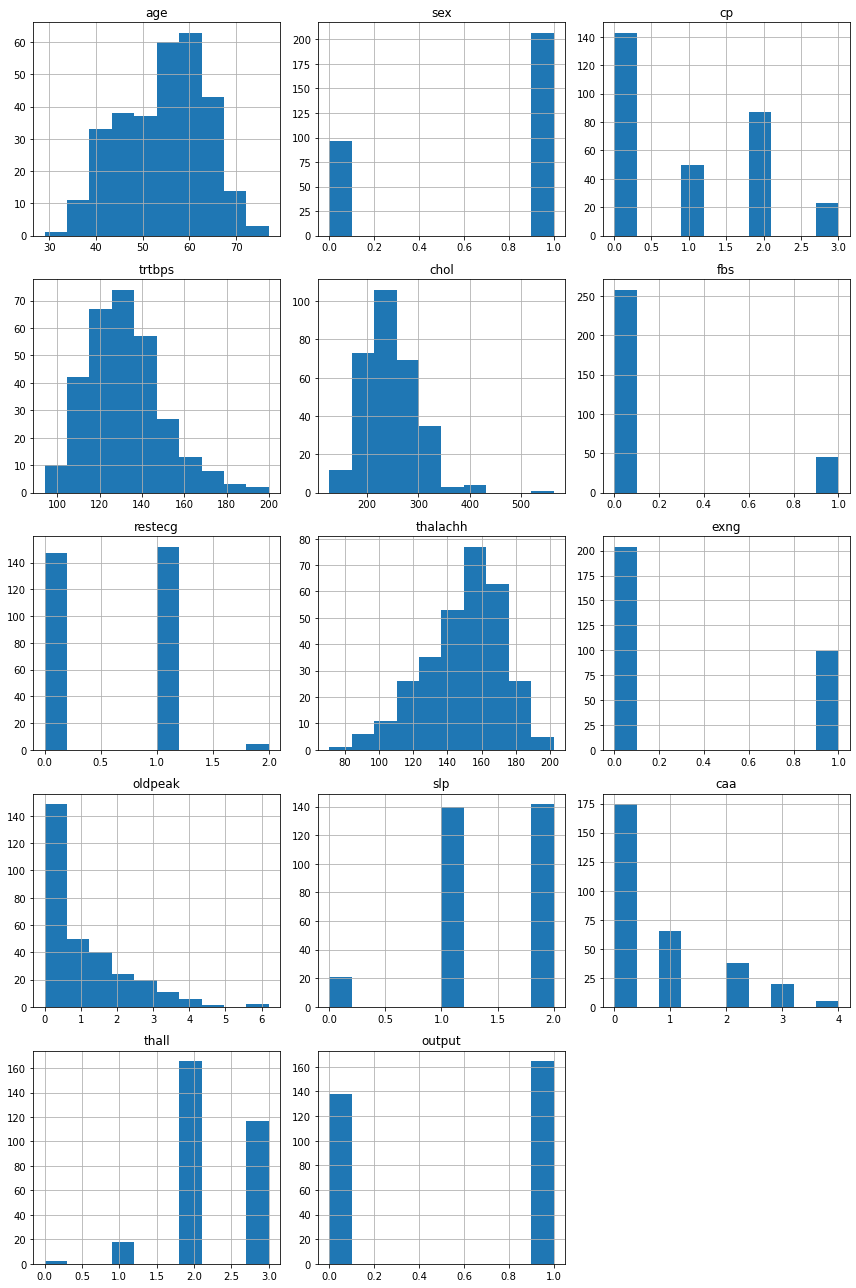

In [8]:
df.hist(layout=(5, 3), figsize=(12, 18))

plt.tight_layout()

Again, everything looks good!

# 2.3. Correlation Chart

Now we can check out the Pearson Correlation Coefficient to see how every feature is correlated with the output.

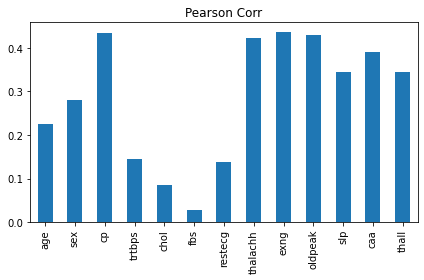

In [9]:
ax = df.corr()['output'][:-1].abs().plot.bar()
ax.set_title('Pearson Corr')
plt.tight_layout()

It seems the features in the middle have relatively low correlation with the output (target).

# 3. Data Transformation and PCA

Now we can try PCA. 
But before applying PCA, we should standardize the dataset since the features have large differences in magnitude.

In [10]:
X = df.iloc[:, :-1].to_numpy().copy()
y = df.iloc[:, -1].to_numpy().copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=rs_num
)

In [11]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

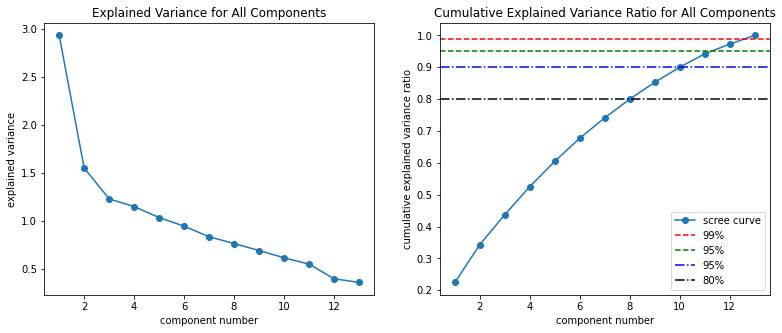

In [12]:
# check out full pca
full_pca = PCA(random_state=rs_num).fit(X_train_scaled)

cu_evr = np.zeros_like(full_pca.explained_variance_ratio_)
for i in range(full_pca.n_components_):
    cu_evr[i] = full_pca.explained_variance_ratio_[:i+1].sum()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(
    np.arange(1, full_pca.n_components_+1, 1), 
    full_pca.explained_variance_, '-o'
)
axes[0].set_xlabel('component number')
axes[0].set_ylabel('explained variance')
axes[0].set_title('Explained Variance for All Components')

axes[1].plot(
    np.arange(1, full_pca.n_components_+1, 1), 
    cu_evr, '-o', label='scree curve'
)
axes[1].axhline(y=0.99, color='red', ls='--', label='99%')
axes[1].axhline(y=0.95, color='green', ls='--', label='95%')
axes[1].axhline(y=0.90, color='blue', ls='-.', label='95%')
axes[1].axhline(y=0.80, color='black', ls='-.', label='80%')
axes[1].set_xlabel('component number')
axes[1].set_ylabel('cumulative explained variance ratio')
axes[1].set_title('Cumulative Explained Variance Ratio for All Components')
axes[1].legend();

The scree plots are interesting, and we can try different threshold levels to see if the PCA dimension reduction would affect the prediction results.

In [13]:
# make an list for the possible component number we may try
component_num_list = []
component_num_list.append(cu_evr[cu_evr<=0.99].shape[0])
component_num_list.append(cu_evr[cu_evr<=0.95].shape[0])
component_num_list.append(cu_evr[cu_evr<=0.90].shape[0])
component_num_list.append(cu_evr[cu_evr<=0.80].shape[0])

print(component_num_list)

[12, 11, 10, 8]


# 4. Training with Algorithms

This section is to try out different algorithms.

Also in this section, we can use `Grid Search` to find the optimal parameters for one pipeline.

Reference:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

## 4.1. SVM with PCA

In [14]:
# first pipeline for the linear SVM and RBF SVM, with PCA
svm_w_PCA_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('pca', PCA(random_state=rs_num)), 
        ('classifier', SVC(random_state=rs_num))
    ]
)

# define CV method
svm_w_PCA_pipeline_cv = RepeatedKFold(
    n_splits=5, n_repeats=3, random_state=rs_num
)

# define grid space
svm_w_PCA_pipeline_param_grid = [
    {
        'pca__n_components': component_num_list, 
        'classifier__kernel': ['linear'], 
        'classifier__C': [0.01, 0.1, 1.0, 10, 100, 1000]
        
    }, 
    {
        'pca__n_components': component_num_list, 
        'classifier__kernel': ['rbf'], 
        'classifier__C': [0.01, 0.1, 1.0, 10, 100, 1000], 
        'classifier__gamma': [0.0001, 0.001, 0.01, 0.1]
    }
]

# construct the grid-search-cv object
svm_w_PCA_pipeline_gscv = GridSearchCV(
    svm_w_PCA_pipeline, param_grid=svm_w_PCA_pipeline_param_grid, cv=svm_w_PCA_pipeline_cv
)

# training and finding
svm_w_PCA_pipeline_gscv.fit(X_train, y_train)

print('Done!')

Done!


In [15]:
# print the best results
print("Best parameter combination found:")
print(svm_w_PCA_pipeline_gscv.best_params_)
print("With scoring:")
print(svm_w_PCA_pipeline_gscv.best_score_)

Best parameter combination found:
{'classifier__C': 10, 'classifier__kernel': 'linear', 'pca__n_components': 10}
With scoring:
0.8623015873015873


Now we can use the optimal parameters to get the actual model.

In [16]:
# instantiate a new pipeline
svm_w_PCA_pipeline_good = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('pca', PCA(random_state=rs_num)), 
        ('classifier', SVC(random_state=rs_num))
    ]
)

# set the parameters using the grid-search results
# ref: https://stackoverflow.com/questions/32965188/scikit-set-params
for k, v in svm_w_PCA_pipeline_gscv.best_params_.items():
    svm_w_PCA_pipeline_good.set_params(**{k: v})
    
# repeated 5-fold cross-validation on the training dataset
svm_w_PCA_pipeline_good_scores = cross_validate(
    svm_w_PCA_pipeline_good, X_train, y_train, 
    cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=rs_num)
)

## 4.2. SVM without PCA

Apply standardization only for the data transformation.

In [17]:
# first pipeline for the linear SVM and RBF SVM, with PCA
svm_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('classifier', SVC(random_state=rs_num))
    ]
)

# define CV method
svm_pipeline_cv = RepeatedKFold(
    n_splits=5, n_repeats=3, random_state=rs_num
)

# define grid space
svm_pipeline_param_grid = [
    {
        'classifier__kernel': ['linear'], 
        'classifier__C': [0.01, 0.1, 1.0, 10, 100, 1000]
        
    }, 
    {
        'classifier__kernel': ['rbf'], 
        'classifier__C': [0.01, 0.1, 1.0, 10, 100, 1000], 
        'classifier__gamma': [0.0001, 0.001, 0.01, 0.1]
    }
]

# construct the grid-search-cv object
svm_pipeline_gscv = GridSearchCV(
    svm_pipeline, param_grid=svm_pipeline_param_grid, cv=svm_pipeline_cv
)

# training and finding
svm_pipeline_gscv.fit(X_train, y_train)

# print the best results
print("Best parameter combination found:")
print(svm_pipeline_gscv.best_params_)
print("With scoring:")
print(svm_pipeline_gscv.best_score_)

Best parameter combination found:
{'classifier__C': 100, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
With scoring:
0.8498866213151927


Now apply the best parameters with new instantiation.

In [18]:
# instantiate a new pipeline
svm_pipeline_good = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('classifier', SVC(random_state=rs_num))
    ]
)

# set the parameters using the grid-search results
# ref: https://stackoverflow.com/questions/32965188/scikit-set-params
for k, v in svm_pipeline_gscv.best_params_.items():
    svm_pipeline_good.set_params(**{k: v})
    
# repeated 5-fold cross-validation on the training dataset
svm_pipeline_good_scores = cross_validate(
    svm_pipeline_good, X_train, y_train, 
    cv=RepeatedKFold(n_splits=5, n_repeats=3, random_state=rs_num)
)

ValueError: Invalid parameter classifier for estimator GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=5, random_state=14),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier', SVC(random_state=14))]),
             param_grid=[{'classifier__C': [0.01, 0.1, 1.0, 10, 100, 1000],
                          'classifier__kernel': ['linear']},
                         {'classifier__C': [0.01, 0.1, 1.0, 10, 100, 1000],
                          'classifier__gamma': [0.0001, 0.001, 0.01, 0.1],
                          'classifier__kernel': ['rbf']}]). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
fig, ax = plt.subplots()

ax.boxplot(
    [
        svm_w_PCA_pipeline_good_scores['test_score'],
        svm_pipeline_good_scores['test_score']
    ], 
    labels=[
        'SVM w/ PCA', 
        'SVM w/o PCA'
    ]
)
ax.set_ylabel('Scores')
ax.set_title('Comparison of 5-Fold CV Scores')

plt.tight_layout()